This model is the most ambitious one. We thought that for a CNN for classification is easier to solve 2 subsequent task because it resembles more the problem of "finding a specific feature in an image" than in a single step:
1. Is there anyone with a mask?
2. Is there someone not wearing a mask?

So we split the problem in 2 classifiers: the first between class 0 and the rest, the second between class 1 and 2. We achieved a score of 0.96222 on the test set.


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

We import libraries, set the seed and the working directory.

In [2]:
import os
import tensorflow as tf
import numpy as np

SEED = 27091997
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We build the generator, we decide the splitting into training and validation set and we augment the training data with only the "admissible" tranformations(for example no vertical flip).
Augmentation doesn't influence too much the model, but it's slightly better because of the scarcity of data.
Proportion of validation is low but enough to be reliable, and we use the most we can for training.

In [4]:
# ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(width_shift_range=15,
                                        height_shift_range=15,
                                        zoom_range=[0.7, 1.3],
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255,
                                        rotation_range=10, 
                                        shear_range=10,                                      
                                        validation_split = 0.1)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255,
                                        validation_split = 0.1)


We import the data and we create a dataframe with the images and their lables.

In [5]:
#Fix the directory structure
import pandas as pd
import json

# unzip 
!unzip '/content/drive/My Drive/artificial-neural-networks-and-deep-learning-2020.zip'

# setting the diectory 
dataset_dir = os.path.join(cwd,'MaskDataset')

# image classes
with open(os.path.join(dataset_dir,'train_gt.json')) as f:
  dic = json.load(f)
dataframe = pd.DataFrame(dic.items())

# create and shuffle dataframe
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe['class'] = dataframe['class'].astype(str)
dataframe = dataframe.sample(frac=1,random_state=27091997).reset_index(drop=True)

Output streaming troncato alle ultime 5000 righe.
  inflating: __MACOSX/MaskDataset/training/._17387.jpg  
  inflating: MaskDataset/training/17393.jpg  
  inflating: __MACOSX/MaskDataset/training/._17393.jpg  
  inflating: MaskDataset/training/15584.jpg  
  inflating: __MACOSX/MaskDataset/training/._15584.jpg  
  inflating: MaskDataset/training/16933.jpg  
  inflating: __MACOSX/MaskDataset/training/._16933.jpg  
  inflating: MaskDataset/training/11084.jpg  
  inflating: __MACOSX/MaskDataset/training/._11084.jpg  
  inflating: MaskDataset/training/13863.jpg  
  inflating: __MACOSX/MaskDataset/training/._13863.jpg  
  inflating: MaskDataset/training/11912.jpg  
  inflating: __MACOSX/MaskDataset/training/._11912.jpg  
  inflating: MaskDataset/training/13877.jpg  
  inflating: __MACOSX/MaskDataset/training/._13877.jpg  
  inflating: MaskDataset/training/15989.jpg  
  inflating: __MACOSX/MaskDataset/training/._15989.jpg  
  inflating: MaskDataset/training/15751.jpg  
  inflating: __MACOSX/M

We create the dataframe to train the first classifier: 

*   Class 0: no person in the image is wearing a mask
*   Class 1: someone in the image is wearing a mask



In [6]:
dataframe2=dataframe.copy()
dataframe2['class'].replace('2','1',inplace=True)
dataframe2

,filename,class
0,10383.jpg,1
1,10615.jpg,1
2,14297.jpg,1
3,10693.jpg,1
4,13880.jpg,1
...,...,...
5609,12358.jpg,1
5610,13889.jpg,0
5611,14123.jpg,0
5612,14857.jpg,0


We create the dataframe to train the second classifier:

*   Class 0: all the people in the image are wearing a mask
*   Class 1: someone in the image is not wearing a mask



In [7]:
dataframe3=dataframe.copy()
dataframe3 = dataframe3[dataframe3['class'] != '0']
dataframe3['class'].replace(['2','1'],['1','0'],inplace=True)
dataframe3.reset_index(drop=True,inplace=True)
dataframe3

,filename,class
0,10383.jpg,0
1,10615.jpg,0
2,14297.jpg,1
3,10693.jpg,0
4,13880.jpg,0
...,...,...
3709,12887.jpg,0
3710,15536.jpg,1
3711,14450.jpg,1
3712,12358.jpg,0


We define the batch size, we fix the dimensions of the images and the number of classes.

In [8]:
# Batch size (Small because with more than this we get OOM error)
bs = 6

# img shape (original dimensions of images used for training EfficientnetB5). We think that by using the original size it can capture better features
img_h = 456
img_w = 456

local_num_classes=2
total_num_classes=3

We read the images from the dataframes created before for both the classifiers.

In [9]:
# First classifier
# Training
training_dir = os.path.join(dataset_dir, 'training')

train_gen = train_data_gen.flow_from_dataframe(dataframe2,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen = train_data_gen.flow_from_dataframe(dataframe2,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs, 
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='validation',
                                               seed=SEED)


Found 5053 validated image filenames belonging to 2 classes.
Found 561 validated image filenames belonging to 2 classes.


In [10]:
# Second classifier
# Training
train_gen2 = train_data_gen.flow_from_dataframe(dataframe3,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen2 = train_data_gen.flow_from_dataframe(dataframe3,
                                               training_dir,
                                               x_col = 'filename',
                                               y_col = 'class',
                                               batch_size=bs, 
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='validation',
                                               seed=SEED)


Found 3343 validated image filenames belonging to 2 classes.
Found 371 validated image filenames belonging to 2 classes.


Now we can use the defined generators. Set on repeat in order to reuse the same images.

In [11]:
#We now finally get the training and validation datasets from the generators - first classifier

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, local_num_classes]))
# Repeat
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, local_num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

In [12]:
#We now finally get the training and validation datasets from the generators - second classifier

train_dataset2 = tf.data.Dataset.from_generator(lambda: train_gen2,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, local_num_classes]))
# Repeat
train_dataset2 = train_dataset2.repeat()

valid_dataset2 = tf.data.Dataset.from_generator(lambda: valid_gen2, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, local_num_classes]))

# Repeat
valid_dataset2 = valid_dataset2.repeat()

We look at the images in one of the batches to see if there are errors and to grasp possible challenges of the problem.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(6, 456, 456, 3)

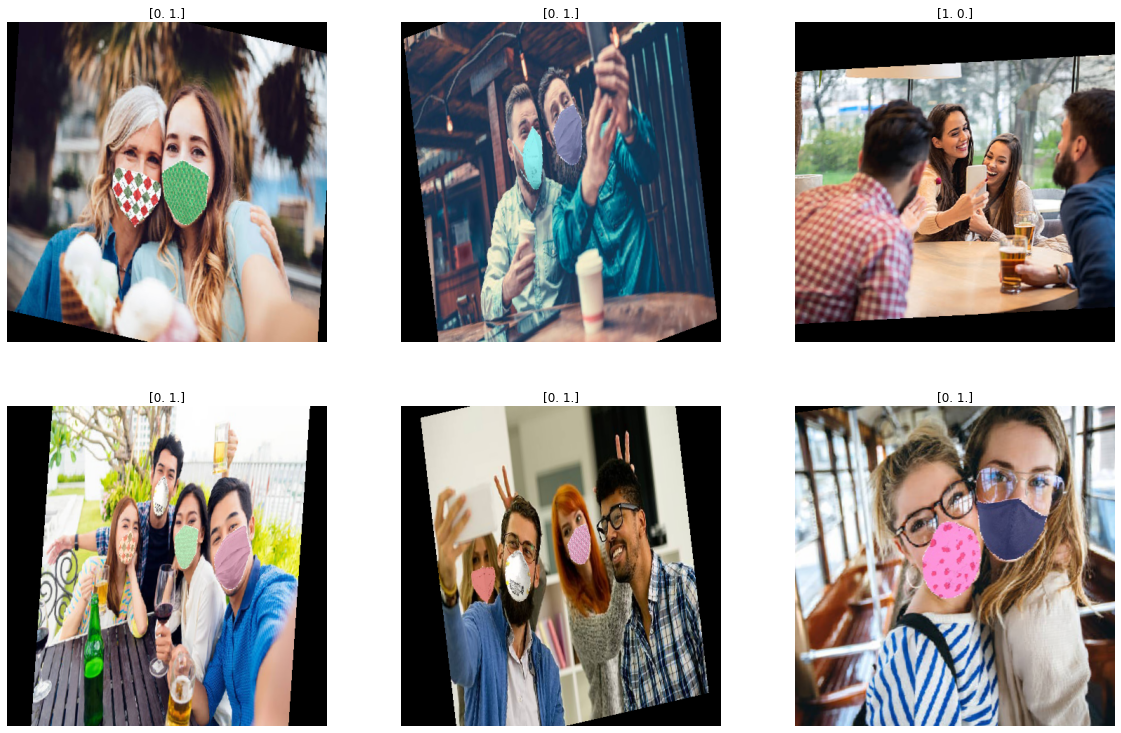

In [13]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(bs):
      ax = plt.subplot(bs/2,bs/2,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')

image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)
image_batch.shape

We install efficientnet in order to use it for transfer learning.

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

     |████████████████████████████████| 51kB 4.0MB/s 


Now we create the model for the first classifier. We use Imagenet weights but since the task is pretty different from that one we finetune the model. In particular, we discovered that a complete finetune (freeze=0) works the best, thanks to the very different nature of the problem and so of the useful features.
At the end there's a global average pooling to reduce the size, a batch normalization to control the outputs, and a dropout to prevent overfitting.

In [ ]:
# Create Model
# ------------
arch = efn.EfficientNetB5(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))


finetuning = True  #We are adapting the parameters to our problem

if finetuning:
    freeze_until = 0 # layer from which we want to fine-tune
    
    for layer in arch.layers[:freeze_until]:
        layer.trainable = False
else:
    arch.trainable = False
    
model = tf.keras.Sequential()
model.add(arch)
model.add(tf.keras.layers.GlobalAveragePooling2D(data_format=None))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=local_num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()


115515392/115515256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 28,517,618
Trainable params: 28,344,882
Non-trainable params: 172,736
_________________________________________________________________


We compile the model

In [ ]:
# Optimization params

# Loss
loss = tf.keras.losses.CategoricalCrossentropy() #Standard choice

# learning rate 
lr = 1e-4   # After some trials, we have found this lr to be good enough to train quickly 
            # without oscillating too much around the final solution

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  


# Validation metrics
metrics = ['accuracy'] # Choice for the challenge


# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

We add some callbacks: early stopping to stop overfit and the learning rate adapter to refine search for minima during training. Then we train the model. (Normally it stops much before 80 epochs). It takes around 4 hours on colab GPU.

In [ ]:
#We add an earlystopping callback and a learning rate adapter callback 
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=False)
LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0)

#We train the first classifier    
model.fit(x=train_dataset,
          epochs=80,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=[es_callback,LR_adapter_callback],
          verbose = 1) #we like to monitor the accuracy during training live ()

Epoch 1/80
843/843 [==============================] - 959s 1s/step - loss: 0.1356 - accuracy: 0.9499 - val_loss: 0.0160 - val_accuracy: 0.9982
Epoch 2/80
843/843 [==============================] - 942s 1s/step - loss: 0.0402 - accuracy: 0.9905 - val_loss: 0.0101 - val_accuracy: 0.9964
Epoch 3/80
843/843 [==============================] - 940s 1s/step - loss: 0.0359 - accuracy: 0.9889 - val_loss: 0.0053 - val_accuracy: 0.9982
Epoch 4/80
843/843 [==============================] - 947s 1s/step - loss: 0.0274 - accuracy: 0.9939 - val_loss: 0.0177 - val_accuracy: 0.9982
Epoch 5/80
843/843 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9951
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
843/843 [==============================] - 938s 1s/step - loss: 0.0206 - accuracy: 0.9951 - val_loss: 0.0140 - val_accuracy: 0.9982
Epoch 6/80
843/843 [==============================] - 939s 1s/step - loss: 0.0141 - accuracy: 0.9966 - val_loss: 0.0223

Now we create the model for the second classifier. We use Imagenet weights but since the task is pretty different from that one we finetune the model. In particular, we discovered that a complete finetune (freeze=0) works the best, thanks to the very different nature of the problem and so of the useful features.
At the end there's a global average pooling to reduce the size, a batch normalization to control the outputs, and a dropout to prevent overfitting.

In [ ]:
# Create Model
# ------------
arch2 = efn.EfficientNetB5(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))


finetuning = True  #We are adapting the parameters to our problem

if finetuning:
    freeze_until = 0 # layer from which we want to fine-tune
    
    for layer in arch2.layers[:freeze_until]:
        layer.trainable = False
else:
    arch2.trainable = False
    
model2 = tf.keras.Sequential()
model2.add(arch2)
model2.add(tf.keras.layers.GlobalAveragePooling2D(data_format=None))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(units=local_num_classes, activation='softmax'))

# Visualize created model as a table
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 28,517,618
Trainable params: 28,344,882
Non-trainable params: 172,736
_________________________________________________________________


We compile the model

In [ ]:
# Optimization params

# Loss
loss2 = tf.keras.losses.CategoricalCrossentropy() #Standard Choice

# learning rate 
lr = 1e-4   # After some trials, we have found this lr to be good enough to train quickly 
            # without oscillating too much around the final solution

optimizer2 = tf.keras.optimizers.Adam(learning_rate=lr)  


# Validation metrics
metrics2 = ['accuracy'] # Choice for the challenge


# Compile Model
model2.compile(optimizer=optimizer2, loss=loss2, metrics=metrics2)

We add some callbacks: early stopping to stop overfit and the learning rate adapter to refine search for minima during training. Then we train the model. (Normally it stops much before 80 epochs). It takes around 4 hours on colab GPU.

In [ ]:
#We add an earlystopping callback and a learning rate adapter callback 
es_callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=True)
LR_adapter_callback2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0)

#We train the second classifier    
model2.fit(x=train_dataset2,
          epochs=80,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen2),
          validation_data=valid_dataset2,
          validation_steps=len(valid_gen2), 
          callbacks=[es_callback2,LR_adapter_callback2],
          verbose = 1) #we like to monitor the accuracy during training live ()

Epoch 1/80
558/558 [==============================] - 625s 1s/step - loss: 0.5096 - accuracy: 0.7481 - val_loss: 0.2260 - val_accuracy: 0.9084
Epoch 2/80
558/558 [==============================] - 623s 1s/step - loss: 0.3193 - accuracy: 0.8717 - val_loss: 0.1633 - val_accuracy: 0.9434
Epoch 3/80
558/558 [==============================] - 622s 1s/step - loss: 0.2400 - accuracy: 0.9082 - val_loss: 0.1460 - val_accuracy: 0.9488
Epoch 4/80
558/558 [==============================] - 624s 1s/step - loss: 0.1824 - accuracy: 0.9330 - val_loss: 0.1382 - val_accuracy: 0.9542
Epoch 5/80
558/558 [==============================] - 625s 1s/step - loss: 0.1408 - accuracy: 0.9506 - val_loss: 0.1196 - val_accuracy: 0.9569
Epoch 6/80
558/558 [==============================] - 622s 1s/step - loss: 0.1264 - accuracy: 0.9566 - val_loss: 0.1359 - val_accuracy: 0.9650
Epoch 7/80
558/558 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.9683
Epoch 00007: ReduceLROnPlateau reducing learni

In [ ]:
# We save the models to reuse them in the final ensemble
model.save(os.path.join('/content/drive/My Drive/ModelloefficientnetB5double1'))
model2.save(os.path.join('/content/drive/My Drive/ModelloefficientnetB5double2'))

Now we make predictions on the test set.

In [ ]:
from PIL import Image
image_filenames = next(os.walk(os.path.join(dataset_dir, 'test')))[2]

results = {}
for image_name in image_filenames:

   img = Image.open(os.path.join(dataset_dir, 'test')+'/'+image_name).convert('RGB')
   img=img.resize((img_h, img_w))
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0) 
   img_array = np.true_divide(img_array,255)
   predictions=model.predict(img_array)
   prediction = np.argmax(predictions)   # predicted class according to the first classifier: we have 0 for all images predicted as 
                                         # 'no person in the image is wearing a mask'; we have 1 for the images predicted as 
                                         # 'someone in the image is wearing a mask': we have to divide them into 2 subclasses
                                         # according to the second classifier
   if prediction!=0:
     predictions=model2.predict(img_array)
     prediction = np.argmax(predictions)    # predicted class according to the second classifier: 0 corresponds to the class '1'
                                            # of the final task; 1 corresponds to the class '2' of the final task
     if prediction==1:
       prediction=2
     else:
       prediction=1
   results[image_name] = prediction

{'10001.jpg': 2,
 '10040.jpg': 2,
 '10074.jpg': 1,
 '10084.jpg': 2,
 '10100.jpg': 2,
 '10120.jpg': 2,
 '10125.jpg': 1,
 '10148.jpg': 1,
 '10213.jpg': 1,
 '10239.jpg': 2,
 '10242.jpg': 1,
 '10259.jpg': 1,
 '10289.jpg': 1,
 '10296.jpg': 0,
 '10323.jpg': 2,
 '10324.jpg': 0,
 '10326.jpg': 2,
 '10328.jpg': 0,
 '10330.jpg': 0,
 '10346.jpg': 0,
 '10349.jpg': 1,
 '10370.jpg': 1,
 '10382.jpg': 2,
 '10396.jpg': 1,
 '10411.jpg': 1,
 '10437.jpg': 2,
 '10459.jpg': 0,
 '10473.jpg': 2,
 '10477.jpg': 2,
 '10494.jpg': 0,
 '10520.jpg': 2,
 '10530.jpg': 1,
 '10571.jpg': 1,
 '10572.jpg': 1,
 '10581.jpg': 2,
 '10620.jpg': 0,
 '10641.jpg': 1,
 '10643.jpg': 1,
 '10662.jpg': 0,
 '10691.jpg': 1,
 '10715.jpg': 2,
 '10727.jpg': 2,
 '10760.jpg': 0,
 '10771.jpg': 1,
 '10782.jpg': 0,
 '10800.jpg': 0,
 '10812.jpg': 1,
 '10845.jpg': 0,
 '10850.jpg': 2,
 '10853.jpg': 1,
 '10863.jpg': 1,
 '10873.jpg': 0,
 '10999.jpg': 2,
 '11012.jpg': 2,
 '11026.jpg': 0,
 '11045.jpg': 1,
 '11115.jpg': 0,
 '11130.jpg': 2,
 '11136.jpg': 

Finally we create the csv file containing the results.

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
create_csv(results, '/content/drive/My Drive')